In [1]:
import sklearn

In [2]:
import numpy as np 
import imutils 
import dlib 
import cv2

from imutils import face_utils 


In [3]:
import sklearn
import cv2
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.models import load_model
#from keras.optimizers import adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda, Conv2DTranspose
from keras.layers import Concatenate
from keras import backend as K
#from keras.utils.multi_gpu_utils import multi_gpu_model
from keras import layers
from tensorflow import keras
import os
import pandas as pd
import tensorflow as tf
import random
import numpy as np
import numpy
from tqdm import tqdm 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import PIL
import pickle

In [4]:
import os
import random

DataSet

In [5]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3074403028406710724
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1788379136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11534705647225574398
physical_device_desc: "device: 0, name: Xavier, pci bus id: 0000:00:00.0, compute capability: 7.2"
xla_global_id: 416903419
]


In [6]:
def image_load(image_file):
    """
    image load, real_image, mask_image 
    """
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    #w = tf.shape(image)[1]
    #w = w // 2

    #real_image = image[:, w:, :]
    #mask_image = image[:, :w, :]

    # Convert both images to float32 tensors
    mask_image = tf.cast(image, tf.float32)
    #real_image = tf.cast(real_image, tf.float32)

    return mask_image

In [7]:
def binary_load(image_file):
    """
    Binary image load
    """
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    input_image = image[:, :, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)

    return input_image

In [8]:
def resize_and_normalize(input_image, real_image, height, width):
  """
  image resize and [-1 ~ 1] normalize
  """
  if real_image is not None:
    input_image = tf.image.resize(input_image, [height, width],preserve_aspect_ratio=False,
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],preserve_aspect_ratio=False,
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

  else:
    input_image = tf.image.resize(input_image, [height, width],preserve_aspect_ratio=False,
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

In [9]:
def load_image_train(image_file):
  mask_image = image_load(image_file)
  mask_image = resize_and_normalize(mask_image, None, 128, 128)

  return mask_image

def load_binary_train(image_file):
  input_image = binary_load(image_file)
  input_image = resize_and_normalize(input_image, None, 128, 128)

  return input_image  

In [10]:
import os
import natsort
 
BATCH_SIZE = 4
TRAIN_MASK_FACE_PATH = 'test/outputs'
TRAIN_BINARY_PATH = 'test/binary_mask'
train_mask_face_file = os.listdir(TRAIN_MASK_FACE_PATH)
train_binary_file = os.listdir(TRAIN_BINARY_PATH)

mask_face_list = [TRAIN_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_mask_face_file)]
binary_list = [TRAIN_BINARY_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_binary_file)]

mask_face_train_dataset = tf.data.Dataset.list_files(mask_face_list, shuffle=False)
mask_face_dataset = mask_face_train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
mask_face_dataset = mask_face_dataset.batch(BATCH_SIZE)

binary_train_dataset = tf.data.Dataset.list_files(binary_list, shuffle=False)
binary_dataset = binary_train_dataset.map(load_binary_train, num_parallel_calls=tf.data.AUTOTUNE)
binary_dataset = binary_dataset.batch(BATCH_SIZE)

In [11]:
Original_face_path='test/inputs'
original_file=os.listdir(Original_face_path)
original_face_list=[Original_face_path+'/'+fileanme for fileanme in natsort.natsorted(original_file)]
original_face_train_dataset = tf.data.Dataset.list_files(original_face_list, shuffle=False)
original_dataset = original_face_train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
original_face_dataset = original_dataset.batch(BATCH_SIZE)

In [12]:
mask_face_dataset

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [13]:
binary_dataset

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

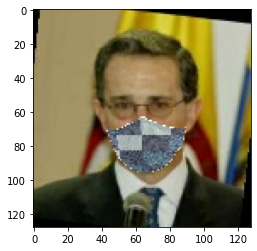

In [14]:
for i, (mask) in enumerate(mask_face_dataset):
  plt.imshow(array_to_img(mask[0]))
  break

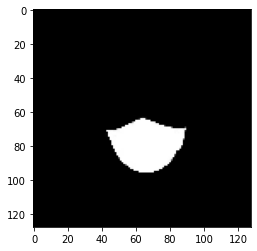

In [15]:

for i, a in enumerate(binary_dataset):
  plt.imshow(array_to_img(a[0]))
  break

Mask Generator

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_batchnorm=False, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
def Mask_Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)

  ]

  up_stack = [
    upsample(512, 3, apply_dropout=False),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  #x = tf.keras.layers.Flatten()(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
import tensorflow as tf  # TF 2.0


class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(
                'Please initialize `TimeDistributed` layer with a '
                '`Layer` instance. You passed: {input}'.format(input=layer))
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.v = self.add_weight(shape=(1, self.w_shape[0] * self.w_shape[1] * self.w_shape[2]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_v',
                                 dtype=tf.float32)

        self.u = self.add_weight(shape=(1, self.w_shape[-1]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_u',
                                 dtype=tf.float32)

        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self.update_weights()
        output = self.layer(inputs)
        self.restore_weights()  # Restore weights because of this formula "W = W - alpha * W_SN`"
        return output
    
    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        
        u_hat = self.u
        v_hat = self.v  # init v vector

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)

                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.v.assign(v_hat)

        self.layer.kernel.assign(self.w / sigma)

    def restore_weights(self):
        self.layer.kernel.assign(self.w)


In [19]:
import tensorflow as tf
#import tensorflow.v1.contrib as tf_contrib


# Xavier : tf_contrib.layers.xavier_initializer()
# He : tf_contrib.layers.variance_scaling_initializer()
# Normal : tf.random_normal_initializer(mean=0.0, stddev=0.02)
# l2_decay : tf_contrib.layers.l2_regularizer(0.0001)

weight_init = tf.compat.v1.keras.initializers.glorot_normal
weight_regularizer = None
weight_regularizer_fully = None

##################################################################################
# Layer
##################################################################################

def conv(x, channels, kernel=4, stride=2, pad=0, pad_type='zero', use_bias=True, sn=False, scope='conv_0'):
    with tf.compat.v1.variable_scope(scope):
        if pad > 0:
            h = x.get_shape().as_list()[1]
            if h % stride == 0:
                pad = pad * 2
            else:
                pad = max(kernel - (h % stride), 0)

            pad_top = pad // 2
            pad_bottom = pad - pad_top
            pad_left = pad // 2
            pad_right = pad - pad_left

            if pad_type == 'zero':
                x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
            if pad_type == 'reflect':
                x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode='REFLECT')

        if sn:
            w = tf.compat.v1.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels], initializer=weight_init,
                                regularizer=weight_regularizer)
            x = tf.nn.conv2d(input=x, filters=spectral_norm(w),
                             strides=[1, stride, stride, 1], padding='VALID')
            if use_bias:
                bias = tf.compat.v1.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                x = tf.nn.bias_add(x, bias)

        else:
            x = tf.layers.conv2d(inputs=x, filters=channels,
                                 kernel_size=kernel, kernel_initializer=weight_init,
                                 kernel_regularizer=weight_regularizer,
                                 strides=stride, use_bias=use_bias)

        return x


def deconv(x, channels, kernel=4, stride=2, padding='SAME', use_bias=True, sn=False, scope='deconv_0'):
    with tf.compat.v1.variable_scope(scope):
        x_shape = x.get_shape().as_list()

        if padding == 'SAME':
            output_shape = [x_shape[0], x_shape[1] * stride, x_shape[2] * stride, channels]

        else:
            output_shape = [x_shape[0], x_shape[1] * stride + max(kernel - stride, 0),
                            x_shape[2] * stride + max(kernel - stride, 0), channels]

        if sn:
            w = tf.compat.v1.get_variable("kernel", shape=[kernel, kernel, channels, x.get_shape()[-1]], initializer=weight_init,
                                regularizer=weight_regularizer)
            x = tf.nn.conv2d_transpose(x, filters=spectral_norm(w), output_shape=output_shape,
                                       strides=[1, stride, stride, 1], padding=padding)

            if use_bias:
                bias = tf.compat.v1.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                x = tf.nn.bias_add(x, bias)

        else:
            x = tf.layers.conv2d_transpose(inputs=x, filters=channels,
                                           kernel_size=kernel, kernel_initializer=weight_init,
                                           kernel_regularizer=weight_regularizer,
                                           strides=stride, padding=padding, use_bias=use_bias)

        return x

def fully_connected(x, units, use_bias=True, sn=False, scope='linear'):
    with tf.compat.v1.variable_scope(scope):
        x = flatten(x)
        shape = x.get_shape().as_list()
        channels = shape[-1]

        if sn:
            w = tf.compat.v1.get_variable("kernel", [channels, units], tf.float32,
                                initializer=weight_init, regularizer=weight_regularizer_fully)
            if use_bias:
                bias = tf.compat.v1.get_variable("bias", [units],
                                       initializer=tf.constant_initializer(0.0))

                x = tf.matmul(x, spectral_norm(w)) + bias
            else:
                x = tf.matmul(x, spectral_norm(w))

        else:
            x = tf.layers.dense(x, units=units, kernel_initializer=weight_init,
                                kernel_regularizer=weight_regularizer_fully,
                                use_bias=use_bias)

        return x

def flatten(x) :
    return tf.layers.flatten(x)

def hw_flatten(x) :
    x_shape=tf.shape(x)
    return tf.reshape(x, [x_shape[0], -1, x_shape[-1]])

##################################################################################
# Residual-block
##################################################################################

def up_resblock(x_init, channels, use_bias=True, is_training=True, sn=False, scope='resblock'):
    with tf.compat.v1.variable_scope(scope):
        with tf.compat.v1.variable_scope('res1'):
            x = batch_norm(x_init, is_training)
            x = relu(x)
            x = up_sample(x, scale_factor=2)
            x = conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=False, sn=sn)

        with tf.compat.v1.variable_scope('res2'):
            x = batch_norm(x, is_training)
            x = relu(x)
            x = conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

        with tf.compat.v1.variable_scope('shortcut'):
            x_init = up_sample(x_init, scale_factor=2)
            x_init = conv(x_init, channels, kernel=1, stride=1, use_bias=False, sn=sn)

        return x + x_init

def down_resblock(x_init, channels, to_down=True, use_bias=True, sn=False, scope='resblock'):
    with tf.compat.v1.variable_scope(scope):
        init_channel = x_init.shape.as_list()[-1]
        with tf.compat.v1.variable_scope('res1'):
            x = lrelu(x_init, 0.2)
            x = conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

        with tf.compat.v1.variable_scope('res2'):
            x = lrelu(x, 0.2)
            x = conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

            if to_down :
                x = down_sample(x)

        if to_down or init_channel != channels :
            with tf.compat.v1.variable_scope('shortcut'):
                x_init = conv(x_init, channels, kernel=1, stride=1, use_bias=use_bias, sn=sn)
                if to_down :
                    x_init = down_sample(x_init)


        return x + x_init

def init_down_resblock(x_init, channels, use_bias=True, sn=False, scope='resblock'):
    with tf.compat.v1.variable_scope(scope):
        with tf.compat.v1.variable_scope('res1'):
            x = conv(x_init, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)
            x = lrelu(x, 0.2)

        with tf.compat.v1.variable_scope('res2'):
            x = conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)
            x = down_sample(x)

        with tf.compat.v1.variable_scope('shortcut'):
            x_init = down_sample(x_init)
            x_init = conv(x_init, channels, kernel=1, stride=1, use_bias=use_bias, sn=sn)

        return x + x_init

##################################################################################
# Sampling
##################################################################################

def global_avg_pooling(x):
    gap = tf.reduce_mean(x, axis=[1, 2])

    return gap

def global_sum_pooling(x) :
    gsp = tf.reduce_sum(x, axis=[1, 2])

    return gsp

def up_sample(x, scale_factor=2):
    _, h, w, _ = x.get_shape().as_list()
    new_size = [h * scale_factor, w * scale_factor]
    return tf.image.resize_nearest_neighbor(x, size=new_size)

def down_sample(x):
    return tf.compat.v1.layers.average_pooling2d(x, pool_size=2, strides=2, padding='SAME')

def max_pooling(x) :
    return tf.compat.v1.layers.max_pooling2d(x, pool_size=2, strides=2, padding='SAME')

##################################################################################
# Activation function
##################################################################################

def lrelu(x, alpha=0.2):
    return tf.nn.leaky_relu(x, alpha)


def relu(x):
    return tf.nn.relu(x)


def tanh(x):
    return tf.tanh(x)

##################################################################################
# Normalization function
##################################################################################

def batch_norm(x, is_training=True, scope='batch_norm'):
    return tf.compat.v1.layers.batch_norm(x,
                                        decay=0.9, epsilon=1e-05,
                                        center=True, scale=True, updates_collections=None,
                                        is_training=is_training, scope=scope)

def spectral_norm(w, iteration=1):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])

    u = tf.compat.v1.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
        """
        power iteration
        Usually iteration = 1 will be enough
        """
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm

##################################################################################
# Loss function
##################################################################################

def discriminator_loss(loss_func, real, fake):
    real_loss = 0
    fake_loss = 0

    if loss_func.__contains__('wgan') :
        real_loss = -tf.reduce_mean(real)
        fake_loss = tf.reduce_mean(fake)

    if loss_func == 'lsgan' :
        real_loss = tf.reduce_mean(tf.squared_difference(real, 1.0))
        fake_loss = tf.reduce_mean(tf.square(fake))

    if loss_func == 'gan' or loss_func == 'dragan' :
        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake), logits=fake))

    if loss_func == 'hinge' :
        real_loss = tf.reduce_mean(relu(1.0 - real))
        fake_loss = tf.reduce_mean(relu(1.0 + fake))

    loss = real_loss + fake_loss

    return loss

def generator_loss(loss_func, fake):
    fake_loss = 0

    if loss_func.__contains__('wgan') :
        fake_loss = -tf.reduce_mean(fake)

    if loss_func == 'lsgan' :
        fake_loss = tf.reduce_mean(tf.squared_difference(fake, 1.0))

    if loss_func == 'gan' or loss_func == 'dragan' :
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake), logits=fake))

    if loss_func == 'hinge' :
        fake_loss = -tf.reduce_mean(fake)

    loss = fake_loss

    return loss

In [20]:

def batch_instance_norm(x, scope='batch_instance_norm'):
    
    with tf.compat.v1.variable_scope(scope,reuse=tf.compat.v1.AUTO_REUSE):
        ch = x.shape[-1]
        eps = 1e-5

        batch_mean, batch_sigma = tf.nn.moments(x, axes=[0, 1, 2], keepdims=True)
        x_batch = (x - batch_mean) / (tf.sqrt(batch_sigma + eps))

        ins_mean, ins_sigma = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        x_ins = (x - ins_mean) / (tf.sqrt(ins_sigma + eps))

        rho = tf.compat.v1.get_variable("rho", [ch], initializer=tf.constant_initializer(1.0), constraint=lambda x: tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0))
        gamma = tf.compat.v1.get_variable("gamma", [ch], initializer=tf.constant_initializer(1.0))
        beta = tf.compat.v1.get_variable("beta", [ch], initializer=tf.constant_initializer(0.0))

        x_hat = rho * x_batch + (1 - rho) * x_ins
        x_hat = x_hat * gamma + beta

        return x_hat

def attention1(x,channels,scope='attention'):
    
    ##more like google attention it is hybrid version
    with tf.compat.v1.variable_scope(scope,reuse=tf.compat.v1.AUTO_REUSE):

        f = conv(x, channels // 8, kernel=1, stride=1, sn=True, scope=scope+'f_conv') # [bs, h, w, c']
        g = conv(x, channels // 8, kernel=1, stride=1, sn=True, scope=scope+'g_conv') # [bs, h, w, c']
        h = conv(x, channels // 2, kernel=1, stride=1, sn=True, scope=scope+'h_conv') # [bs, h, w, c
        gamma=tf.compat.v1.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))
        f_flatten = hw_flatten(f)
        g_flatten = hw_flatten(g)
        h_flatten = hw_flatten(h)
        
        s = tf.matmul(g_flatten, f_flatten, transpose_b=True) # [B,N,C] * [B, N, C] = [B, N, N]
        b = tf.nn.softmax(s, axis=-1)
        o = tf.matmul(b, h_flatten)
        batch_size, height, width, num_channels = x.get_shape().as_list()
        o = tf.reshape(o, tf.shape(x))
        o = conv(o,channels // 2,kernel=1,stride=1,sn=True,scope=scope+"attn_conv")
        y = gamma * o + x


            
        return y

class maskgeneration:
    def prepare_model(self, input_size=(128,128,3),start_channel=32):
        inputs = tf.keras.layers.Input(input_size)
        s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

        c0 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(s) ##input channel 3 output 16
        c0 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c0) ##input channel 3 output 16 
        c0 = batch_instance_norm(c0)
        c0 = tf.nn.leaky_relu(c0)
        p0 = tf.keras.layers.MaxPooling2D((2,2))(c0)
        #Contraction path
        c1 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p0) ##input channel 3 output 16
        c1 = batch_instance_norm(c1)
        c1 = tf.nn.leaky_relu(c1)
        c1 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c1) ##------>
        c1 = batch_instance_norm(c1)
        c1 = tf.nn.leaky_relu(c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) ##

        c2 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p1)
        c2 = batch_instance_norm(c2)
        c2 = tf.nn.leaky_relu(c2)
        c2 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c2) ##------>
        c2 = batch_instance_norm(c2)
        c2 = tf.nn.leaky_relu(c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) ##
        
        #c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = attention1(x=p2,channels=start_channel*8,scope='self_attention')
        c3 = batch_instance_norm(c3)
        c3 = tf.nn.leaky_relu(c3)
        c3 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c3) ##----->
        c3 = batch_instance_norm(c3)
        c3 = tf.nn.leaky_relu(c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) ##
        
        #c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = attention1(x=p3,channels=start_channel*16,scope='self_attention')
        c4 = batch_instance_norm(c4)
        c4 = tf.nn.leaky_relu(c4)
        c4 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c4) ##----->
        c4 = batch_instance_norm(c4)
        c4 = tf.nn.leaky_relu(c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4) ##

        ##Bottelneck 
        c5 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p4)
        c5 = batch_instance_norm(c5)
        c5 = tf.nn.leaky_relu(c5)
        c5 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c5) ##----->
        c5 = batch_instance_norm(c5)
        c5 = tf.nn.leaky_relu(c5)

        #Expansive path 
        u6 = tf.keras.layers.Conv2DTranspose(start_channel*16, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u6)
        c6 = batch_instance_norm(c6)
        c6 = tf.nn.leaky_relu(c6)
        c6 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c6) ##------>
        c6 = batch_instance_norm(c6)
        c6 = tf.nn.leaky_relu(c6)
        
        u7 = tf.keras.layers.Conv2DTranspose(start_channel*8, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u7)
        c7 = batch_instance_norm(c7)
        c7 = tf.nn.leaky_relu(c7)
        c7 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c7)
        c7 = batch_instance_norm(c7)
        c7 = tf.nn.leaky_relu(c7)
        
        u8 = tf.keras.layers.Conv2DTranspose(start_channel*4, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u8)
        c8 = batch_instance_norm(c8)
        c8 = tf.nn.leaky_relu(c8)
        c8 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c8)
        c8 = batch_instance_norm(c8)
        c8 = tf.nn.leaky_relu(c8)
        
        u9 = tf.keras.layers.Conv2DTranspose(start_channel*2, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
        c9 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u9)
        c9 = batch_instance_norm(c9)
        c9 = tf.nn.leaky_relu(c9)
        c9 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c9)
        c9 = batch_instance_norm(c9)
        c9 = tf.nn.leaky_relu(c9)

        u10 = tf.keras.layers.Conv2DTranspose(start_channel, (2, 2), strides=(2, 2), padding='same')(c9)
        u10 = tf.keras.layers.concatenate([u10, c0], axis=3)
        c10 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u10)
        c10 = batch_instance_norm(c10)
        c10 = tf.nn.leaky_relu(c10)
        c10 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c10)
        c10 = batch_instance_norm(c10)
        c10 = tf.nn.leaky_relu(c10)
        #initializer = tf.random_normal_initializer(0., 0.02)
        #outputs= tf.keras.layers.Conv2DTranspose(3, 3,strides=2,padding='same',kernel_initializer=initializer,activation='tanh')(c10)
        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)
        
        return tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [21]:
mask_generator = Mask_Generator()

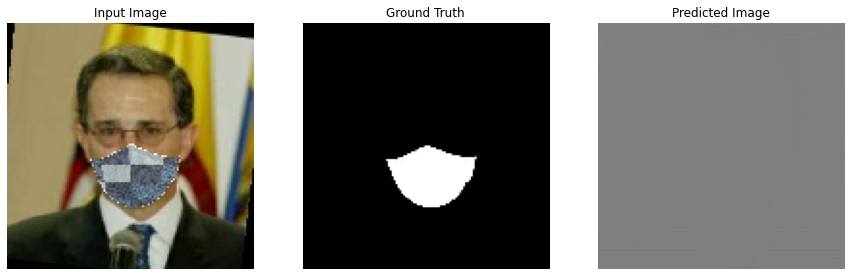

In [22]:
def generate_images(model, test_input, tar):
  """
  Generate
  Args:
    model : Generate model
  """
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

ff=mask_face_dataset.as_numpy_iterator().next()
gg=binary_dataset.as_numpy_iterator().next()
generate_images(mask_generator,ff , gg)
 

In [23]:
sparseCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(gen_output, target):
  #gan_loss = sparseCE(target, gen_output)
  # Mean absolute error
  l1_loss = 100 * tf.reduce_mean(tf.abs(target - gen_output))
  # total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return l1_loss

In [24]:
# @tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = mask_generator(input_image, training=True)
    
    # L1 loss
    gen_loss = generator_loss(gen_output, target)
    
  generator_gradients = gen_tape.gradient(gen_loss,
                                          mask_generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          mask_generator.trainable_variables))

In [25]:
import time
from IPython import display

def fit(train_ds, test_ds, epoch):

  dataSet = tf.data.Dataset.zip((train_ds, test_ds))  
  for num in range(epoch):
    start = time.time()
    for step, (mask_input,target) in enumerate(dataSet):
      if (step) % 100 == 0:
        display.clear_output(wait=True)
        if step != 0:
          print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')
        start = time.time()
        generate_images(mask_generator, mask_input, target)
        print(f"Step: {step//100}")

      train_step(mask_input, target, step)

      # Training step
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)

      # Save (checkpoint) the model every 800 steps
      if (step + 1) % 10 == 0:
        mask_generator.save("_training_checkpoints/mask_model_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))

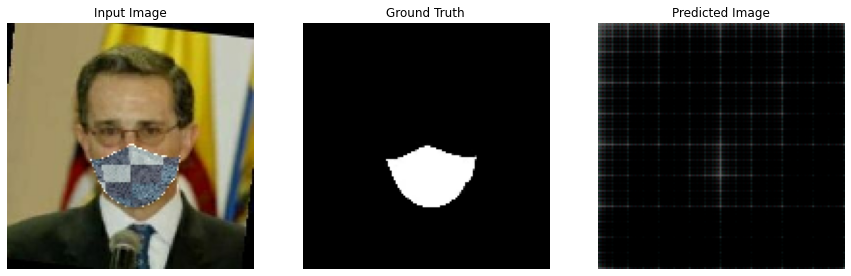

Step: 0


In [29]:
#fit(mask_face_dataset, binary_dataset, epoch=4)

In [40]:
mask_generator.load_weights('training_checkpoints/mask_model_epoch100_step20.h5')

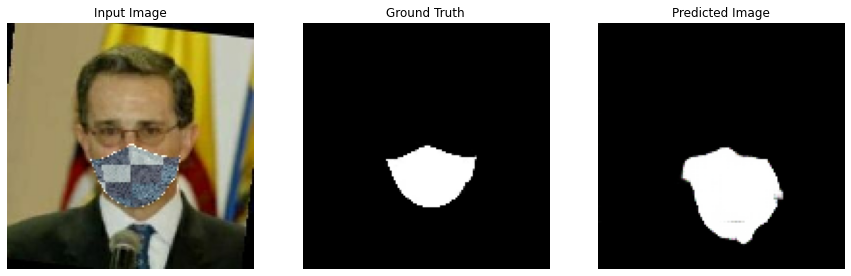

In [41]:
ff=mask_face_dataset.as_numpy_iterator().next()
gg=binary_dataset.as_numpy_iterator().next()
generate_images(mask_generator,ff , gg)

In [42]:
import numpy as np
import cv2
def noise_processing(mask_image, generate_image):
    """
    Mask Generator
    Args:
      mask_image : 
      generate_image : 
    Return:
      Noiser
    """
    images = []
    noise = np.random.rand(128, 128, 3)*255.0
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    batch = mask_image.shape[0]

    for i in range(batch):
        image = mask_image[i, :, :, :]
        mask = generate_image[i, :, :, :]
        # mask = cv2.erode(mask, k)             #  mask  Morphology 연산 전처리
        # mask = cv2.dilate(mask, k)

        mask = (mask + 1) * 127.5
        image = (image + 1) * 127.5
        image = image.numpy()
        # _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)   #  mask 전처리
        
        # Masking된 RGB채널에 노이즈 생성
        image1 = np.where(mask[:,:,0] == 0, image[:, :, 0], noise[:,:,0])
        image2 = np.where(mask[:,:,1] == 0, image[:, :, 1], noise[:,:,1])
        image3 = np.where(mask[:,:,2] == 0, image[:, :, 2], noise[:,:,2])

        image1 = image1[:, :, np.newaxis]
        image2 = image2[:, :, np.newaxis]
        image3 = image3[:, :, np.newaxis]

        noise_image = np.concatenate([image1, image2], axis=-1)
        noise_image = np.concatenate([noise_image, image3], axis=-1)

        images.append(noise_image[np.newaxis, :, :, :])

    image_input = np.array(images).reshape((batch, 128, 128, 3))
    image_input = tf.convert_to_tensor(image_input, dtype=tf.float32)
    return (image_input / 127.5) - 1

In [43]:
dataSet = tf.data.Dataset.zip((mask_face_dataset, binary_dataset))

for step, (a, c) in enumerate(dataSet):
  aa = mask_generator(a, training=False)
  image = noise_processing(a, aa)
  break

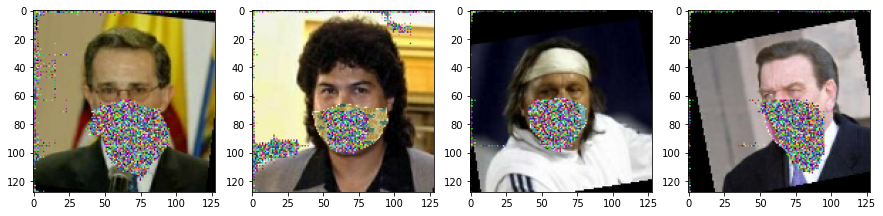

In [44]:
plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))

Face Generator

In [45]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [46]:
class facegeneration:
    
    def prepare_model(self, input_size=(128,128,3),start_channel=32):
        inputs_mask = tf.keras.layers.Input(input_size)
        #inputs_map = tf.keras.layers.Input(input_size[1])
        #inputs = tf.keras.layers.concatenate([inputs_mask, inputs_map])
        s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs_mask)

        c0 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(s) ##input channel 3 output 16
        c0 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c0) ##input channel 3 output 16 
        c0 = batch_instance_norm(c0)
        c0 = tf.nn.leaky_relu(c0)
        p0 = tf.keras.layers.MaxPooling2D((2,2))(c0)
        #Contraction path
        c1 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p0) ##input channel 3 output 16
        c1 = batch_instance_norm(c1)
        c1 = tf.nn.leaky_relu(c1)
        c1 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c1) ##------>
        c1 = batch_instance_norm(c1)
        c1 = tf.nn.leaky_relu(c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) ##

        c2 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p1)
        c2 = batch_instance_norm(c2)
        c2 = tf.nn.leaky_relu(c2)
        c2 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c2) ##------>
        c2 = batch_instance_norm(c2)
        c2 = tf.nn.leaky_relu(c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) ##
        
        #c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = attention1(x=p2,channels=start_channel*8,scope='self_attention')
        c3 = batch_instance_norm(c3)
        c3 = tf.nn.leaky_relu(c3)
        c3 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c3) ##----->
        c3 = batch_instance_norm(c3)
        c3 = tf.nn.leaky_relu(c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) ##
        
        #c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = attention1(x=p3,channels=start_channel*16,scope='self_attention')
        c4 = batch_instance_norm(c4)
        c4 = tf.nn.leaky_relu(c4)
        c4 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c4) ##----->
        c4 = batch_instance_norm(c4)
        c4 = tf.nn.leaky_relu(c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4) ##

        ##Bottelneck 
        c5 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(p4)
        c5 = batch_instance_norm(c5)
        c5 = tf.nn.leaky_relu(c5)
        c5 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c5) ##----->
        c5 = batch_instance_norm(c5)
        c5 = tf.nn.leaky_relu(c5)

        #Expansive path 
        u6 = tf.keras.layers.Conv2DTranspose(start_channel*16, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u6)
        c6 = batch_instance_norm(c6)
        c6 = tf.nn.leaky_relu(c6)
        c6 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c6) ##------>
        c6 = batch_instance_norm(c6)
        c6 = tf.nn.leaky_relu(c6)
        
        u7 = tf.keras.layers.Conv2DTranspose(start_channel*8, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u7)
        c7 = batch_instance_norm(c7)
        c7 = tf.nn.leaky_relu(c7)
        c7 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c7)
        c7 = batch_instance_norm(c7)
        c7 = tf.nn.leaky_relu(c7)
        
        u8 = tf.keras.layers.Conv2DTranspose(start_channel*4, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u8)
        c8 = batch_instance_norm(c8)
        c8 = tf.nn.leaky_relu(c8)
        c8 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c8)
        c8 = batch_instance_norm(c8)
        c8 = tf.nn.leaky_relu(c8)
        
        u9 = tf.keras.layers.Conv2DTranspose(start_channel*2, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
        c9 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u9)
        c9 = batch_instance_norm(c9)
        c9 = tf.nn.leaky_relu(c9)
        c9 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c9)
        c9 = batch_instance_norm(c9)
        c9 = tf.nn.leaky_relu(c9)

        u10 = tf.keras.layers.Conv2DTranspose(start_channel, (2, 2), strides=(2, 2), padding='same')(c9)
        u10 = tf.keras.layers.concatenate([u10, c0], axis=3)
        c10 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(u10)
        c10 = batch_instance_norm(c10)
        c10 = tf.nn.leaky_relu(c10)
        c10 = SpectralNormalization(tf.keras.layers.Conv2D(start_channel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))(c10)
        c10 = batch_instance_norm(c10)
        c10 = tf.nn.leaky_relu(c10)

        
        outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='tanh')(c10)
        
        return tf.keras.models.Model(inputs=[inputs_mask], outputs=[outputs])

In [47]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [48]:
face_generator = facegeneration().prepare_model()
discriminator = Discriminator()

In [49]:
LAMBDA = 100
face_generator_BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [51]:
def face_generator_loss(disc_generated_output, gen_output, target):
  gan_loss = face_generator_BCE(tf.ones_like(disc_generated_output), disc_generated_output)
  ssim_loss = tf.image.ssim(target, gen_output, max_val=1.0)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = ssim_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = face_generator_BCE(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = face_generator_BCE(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss  

In [52]:
def generate_images2(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [53]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = face_generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, _, _= face_generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          face_generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          face_generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [54]:
def fit(train_ds, original_ds,test_ds, epoch):

  dataSet = tf.data.Dataset.zip((train_ds, original_ds, test_ds))  
  for num in range(epoch):
    start = time.time()

    for step, (mask_input, real_input, target) in enumerate(dataSet):
      input_image = mask_generator(mask_input, training=False)
      input_image = noise_processing(mask_input, input_image)
      if (step) % 100 == 0:
        display.clear_output(wait=True)

        if step != 0:
          print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

        start = time.time()

        generate_images2(face_generator, input_image, real_input)
        print(f"Step: {step//100}")

      train_step(input_image, real_input, step)

      # Training step
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)


      # Save (checkpoint) the model every 600 steps
      if (step + 1) % 10 == 0:
          face_generator.save_weights("_training_checkpoints3/generator/face_gen_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))
          discriminator.save("_training_checkpoints3/discriminator/face_dis_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))


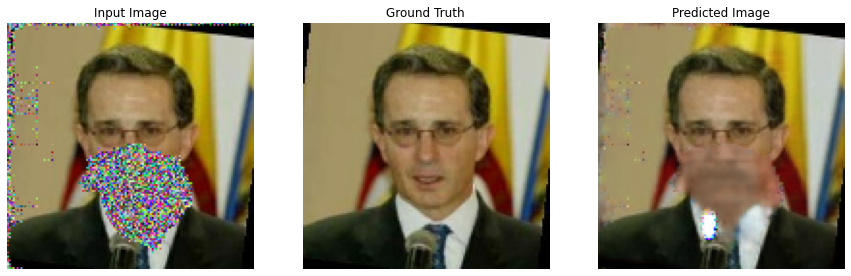

Step: 0


In [57]:
fit(mask_face_dataset,original_face_dataset, binary_dataset, epoch=250)

Model Test

In [58]:
TEST_MASK_FACE_PATH = '/home/mrinmoy/mask removal/test/outputs'
test_files = os.listdir(TEST_MASK_FACE_PATH)
test_files = [TEST_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(test_files)]

test_dataset = tf.data.Dataset.list_files(test_files, shuffle=False)
test_dataset = test_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

GAN Loss + L1 Loss

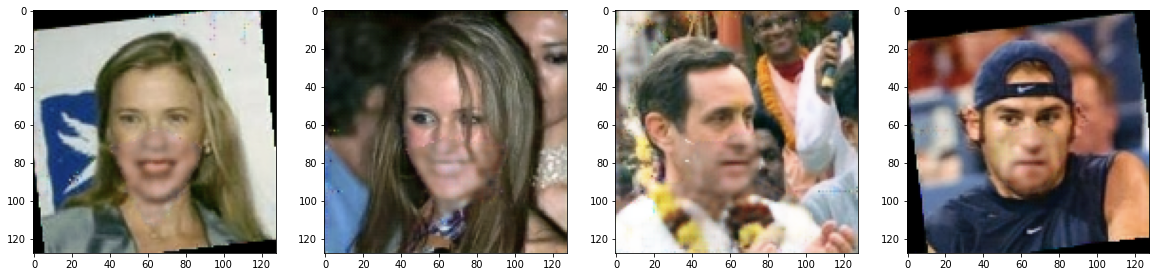

In [69]:
face_generator.load_weights('/home/mrinmoy/mask removal/_training_checkpoints3/generator/face_gen_epoch49_step20.h5')
discriminator.load_weights('/home/mrinmoy/mask removal/_training_checkpoints3/discriminator/face_dis_epoch49_step20.h5')

for step, (mask_face )in enumerate(test_dataset):
  mask = mask_generator(mask_face, training=False)
  image = noise_processing(mask_face, mask)
  image = face_generator(image, training=False)
  if step == 1:
    break
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))    

SSIM Loss + L1 Loss

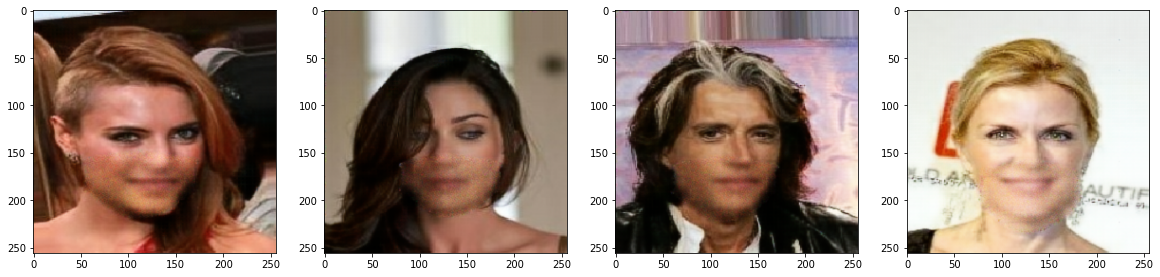

In [ ]:
face_generator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints3/face_gen_epoch10_step600.h5')
discriminator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints3/face_dis_epoch10_step600.h5')

for step, (mask_face, real_image )in enumerate(test_dataset):
  mask = mask_generator(mask_face, training=False)
  image = noise_processing(mask_face, mask)
  image = face_generator(image, training=False)
  if step == 1:
    break

plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))

Real image TEST

Furture work progress... 